In [115]:
import cmocean
import logging
import numpy as np
import seaborn as sns
import dask.array as da
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from dask import delayed, compute
from scipy.interpolate import interp2d
from dask.distributed import Client, progress
from matplotlib.colors import LogNorm, TwoSlopeNorm, SymLogNorm, Normalize

sns.set()
sns.set_style("ticks")

In [3]:
from spectral_analysis.common_vars.time_slices import idx_t
from spectral_analysis.common_vars.directories import LUIGI_OUT_FOLDER,POSTPROCESS_OUT_FOLDER
from spectral_analysis.common_vars.regions import ids_regions,lats4id,lons4id,faces_regions
#from spectral_analysis.isotropic_spectra.spectral_kinema import spectral_kinematics
#from spectral_analysis.isotropic_spectra.isotropic import calc_ispec
from spectral_analysis.luigi_workflows.llc_region import LLCRegion
#from spectral_analysis.luigi_workflows.output import theta4idt,Theta4id,uv4idt,UV4id,heatFlux4idt,HF4id,hbl4idt,KPPhbl4id,VorticityGrid,Tau4id,tau4idt

In [97]:
from importlib import reload
%load_ext autoreload
%autoreload
import spectral_analysis.luigi_workflows.output
reload(spectral_analysis.luigi_workflows.output)
import spectral_analysis
reload(spectral_analysis)
import spectral_analysis.luigi_workflows
reload(spectral_analysis.luigi_workflows)
import spectral_analysis.luigi_workflows.llc_region
reload(spectral_analysis.luigi_workflows.llc_region)
from spectral_analysis.luigi_workflows.llc_region import LLCRegion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
client = Client(threads_per_worker=4, n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:35873 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 40 Memory: 33.73 GB


In [103]:
season = "JFM"
region = "Canarias"
rid = ids_regions[region][2]
region = LLCRegion(rid, idx_t["hours"][season][30:31], tag=season)

2021-08-19 06:24:12 INFO     Grid: dx = 2.1525167858620695 km, dy = 1.9787329799999998 km, dt = 1 h
2021-08-19 06:24:12 INFO     Exists? 730: _JFM -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/730_JFM_hours.npz
2021-08-19 06:24:12 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km']


In [6]:
XC, YC = region.getGridC()
XG, YG = region.getGridG()

In [7]:
region.loadScalar("U")
region.loadScalar("V")

2021-08-18 21:59:40 INFO     Loading U: shape (k=0): (290, 289, 1)
2021-08-18 21:59:40 INFO     Loading V: shape (k=0): (290, 289, 1)


In [8]:
U_ = region.get("U")[:,:,0]
V_ = region.get("V")[:,:,0]

In [9]:
print(XC.shape, YC.shape)
print(XG.shape, YG.shape)
print(U_.shape, V_.shape)

(290, 289) (290, 289)
(290, 289) (290, 289)
(290, 289) (290, 289)


In [10]:
nmax=-1
print("XG", np.min(XG), np.max(XG))
print("XC", np.min(XC), np.max(XC))
print("XC*", np.min(XC[::,:nmax]), np.max(XC[::,:nmax]))
print("YG", np.min(YG), np.max(YG))
print("YC", np.min(YC), np.max(YC))
print("YC*", np.min(YC[:nmax,::]), np.max(YC[:nmax,::]))

XG -26.0 -20.0
XC -25.989584 -19.989584
XC* -25.989584 -20.010416
YG 19.032818 24.17676
YC 19.041874 24.185495
YC* 19.041874 24.168024


In [11]:
def plot_uv(U__, V__):
  with sns.axes_style("whitegrid"):
    min_vel = min(np.min(U__), np.min(V__))
    max_vel = max(np.max(U__), np.max(V__))
    norm = TwoSlopeNorm(vmin=min_vel, vmax=max_vel, vcenter=0)
    cmap = plt.cm.RdBu_r
    #
    plt.figure()
    plt.pcolormesh(XG, YC, U__, norm=norm, cmap=cmap)
    plt.colorbar()
    plt.show()
    #
    plt.figure()
    plt.pcolormesh(XC, YG, V__, norm=norm, cmap=cmap)
    plt.colorbar()
    plt.show()
    #
    plt.figure(figsize=(10,10))
    nn_=5
    plt.quiver(XC[::nn_,::nn_], YC[::nn_,::nn_], U__[::nn_,::nn_], V__[::nn_,::nn_])
    plt.show()

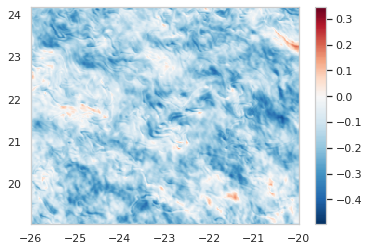

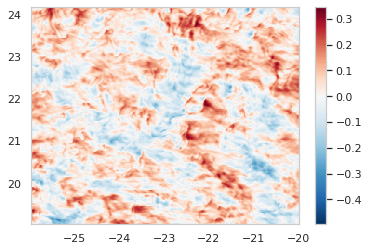

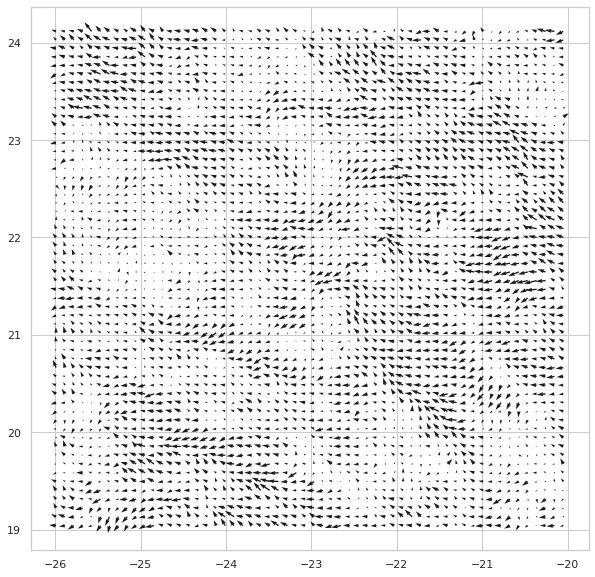

In [12]:
plot_uv(U_, V_)

In [42]:
def interpolate_mesh(Xi, Yi, F, X, Y, kind='linear'):
    print("local F.size: ", F.size)
    interpolant = interp2d(Xi, Yi, F, kind=kind)
    res = [interpolant(x,y) for x,y in zip(X, Y)]
    return np.reshape(res, X.shape)

In [19]:
%time U = interpolate_mesh(XG, YC, U_, XC.ravel(), YC.ravel())

local F.size:  83810
CPU times: user 18min 40s, sys: 8.57 s, total: 18min 49s
Wall time: 18min 34s


In [20]:
%time V = interpolate_mesh(XC, YG, V_, XC.ravel(), YC.ravel())

local F.size:  83810
CPU times: user 18min 9s, sys: 8.32 s, total: 18min 18s
Wall time: 18min 3s


In [27]:
print("shape UV", U.shape, V.shape)

shape UV (290, 289) (290, 289)


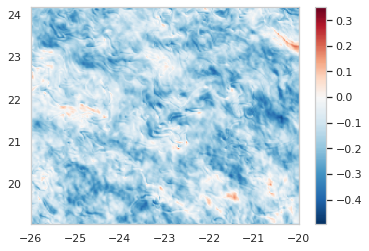

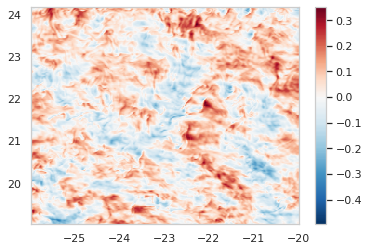

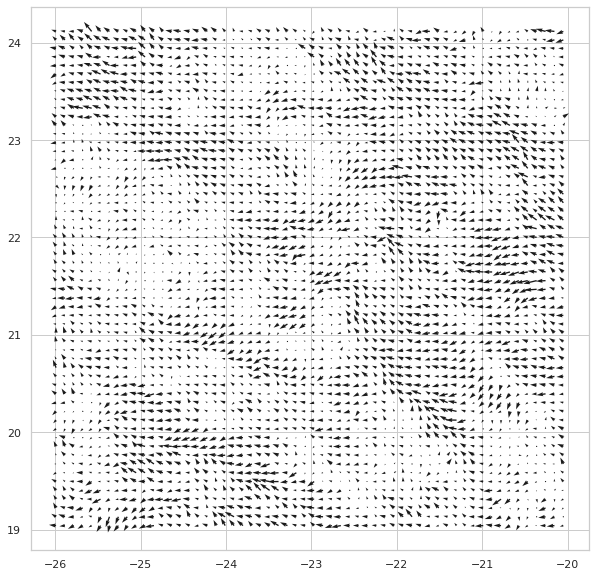

In [28]:
plot_uv(U, V)

In [33]:
print("Umin", np.min(U_), np.min(U))
print("Umax", np.max(U_), np.max(U))
print("Vmin", np.min(V_), np.min(V))
print("Vmax", np.max(V_), np.max(V))

Umin -0.4966563880443573 -0.4966563880443573
Umax 0.1976448893547058 0.19673984558531135
Umin -0.31705889105796814 -0.34370355879187214
Umax 0.3462830185890198 0.3521295647222883


## Horizontal advection

In [106]:
reg_ = LLCRegion(rid, idx_t["hours"][season], tag=season)
advU, advV = reg_.adv_2d("adv")

2021-08-19 06:25:19 INFO     Grid: dx = 2.1525167858620695 km, dy = 1.9787329799999998 km, dt = 1 h
2021-08-19 06:25:19 INFO     Exists? 730: _JFM -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/730_JFM_hours.npz
2021-08-19 06:25:19 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km']
2021-08-19 06:25:19 INFO     Loading U: shape (k=0): (290, 289, 2184)
2021-08-19 06:25:42 INFO     Loading V: shape (k=0): (290, 289, 2184)
2021-08-19 06:25:58 INFO     Calculating adv_x + adv_y = (u*grad_x)adv + (v*grad_y)adv


In [108]:
print("shape adv_UV", advU.shape, advV.shape)

shape adv_UV (2184, 290, 289) (2184, 290, 289)


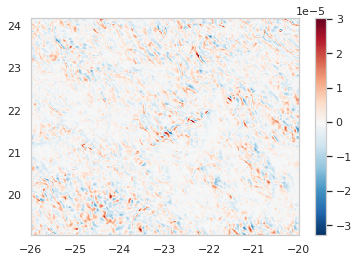

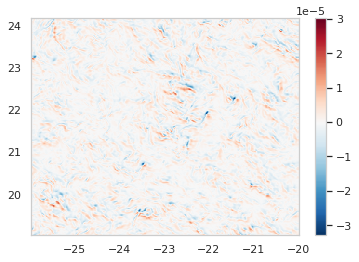

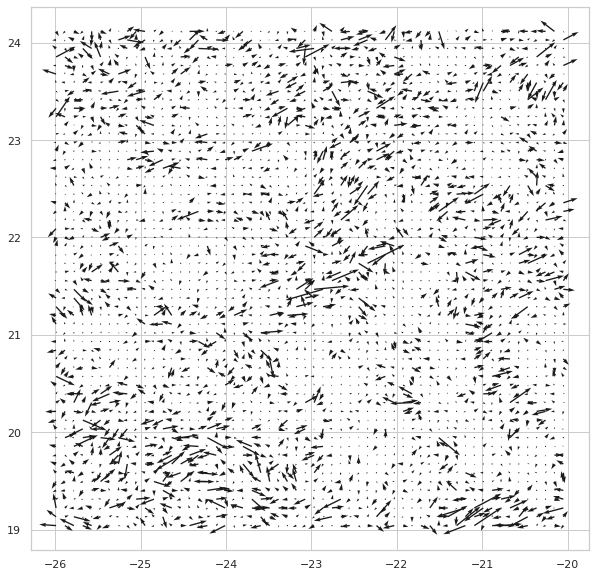

In [110]:
tt = 10
plot_uv(advU[tt,:,:], advV[tt,:,:])

### Energy transfer

In [116]:
reg_.cospectrum("adv_x", "U", "ADV_x")
reg_.cospectrum("adv_y", "V", "ADV_y")
adv_S = reg_.get_spectrum("ADV_x") + reg_.get_spectrum("ADV_y")

ki = region.get_spectrum("k_h")
logging.info("K: ({}, {})".format(np.min(ki), np.max(ki)))
omega = region.get_spectrum("om")
logging.info("omega: ({}, {})".format(np.min(omega), np.max(omega)))
logging.info("ADV(k) shape: {}".format(adv_S.shape))

2021-08-19 06:31:37 INFO     Cospectrum ADV_x already there
2021-08-19 06:31:37 INFO     Cospectrum ADV_y already there
2021-08-19 06:31:37 INFO     K: (0.0008650519031141862, 0.2465397923875431)
2021-08-19 06:31:37 INFO     omega: (0.0, 0.5)
2021-08-19 06:31:37 INFO     ADV(k) shape: (144, 1093)


In [130]:
print("ADV range:", np.min(adv_S), np.max(adv_S))

ADV range: -0.006070157190425635 0.0015786887751641004


In [166]:
xlims = [1/150,1/8]
xticks = [1/10,1/25,1/50,1/80,1/150]
xticksLabel = ['10','25','50','80','150']
yticks = [1/3,1/6,1/12,1/24,1/(24*7),1/(24*30)]
yticksLabel = ['3 h','6 h','12 h','1 d','1 w','1 mo']
# Lt plots
xticks_ = [1/10,1/20,1/30,1/40,1/50,1/75,1/100,1/150]
xticksLabel_ = ['10','20','30','40','50','75','100','150']

def plot_cospectra(ki, omega, S, title, linthresh=5e-11, cmap='bwr', vminmax=None, bottom=False, k_scale=True):
    logging.info("{} - {} (type={}), {} (type={}), {} (type={})".format(title, S.shape, S.dtype, omega.shape, omega.dtype, ki.shape, ki.dtype))
    plt.figure(figsize=(8,6))
    SS = (omega*S).T*ki if k_scale else S.T
    if vminmax is None:
        vmin = np.min(abs(SS))
        vmax = np.max(abs(SS))
    else:
        vmin=vminmax[0]
        vmax=vminmax[1]
    vcenter = (vmin+vmax)/2 if vmin>=0 else 0
    print("Vminmaxcenter",vmin,vmax,vcenter)
    #norm = TwoSlopeNorm(vmin=vmin, vmax=vmax, vcenter=vcenter)
    norm = SymLogNorm(linthresh, vmin=vmin, vmax=vmax, base=10)
    logging.info("SS: {}, vminmax = {}".format(SS.shape, vminmax))
    plt.pcolormesh(ki, omega, SS, norm=norm, cmap=cmap)
    plt.xscale('log')
    plt.xticks(xticks,xticksLabel)
    plt.xlim(xlims)
    plt.yscale('log')
    plt.ylim([omega[1],omega[-100]])
    plt.yticks(yticks,yticksLabel)
    plt.colorbar()
    if bottom:
      plt.xlabel('Horizontal scales [km]', size='large')
    plt.ylabel('Time scales', size='large')
    plt.title(title, size='x-large')
    #plt.show()

2021-08-19 22:48:28 INFO     ADV($\omega$,k) - (143, 1093) (type=float64), (1093,) (type=float64), (143,) (type=float64)
2021-08-19 22:48:28 INFO     SS: (1093, 143), vminmax = [-5e-07, 5e-07]


Vminmaxcenter -5e-07 5e-07 0


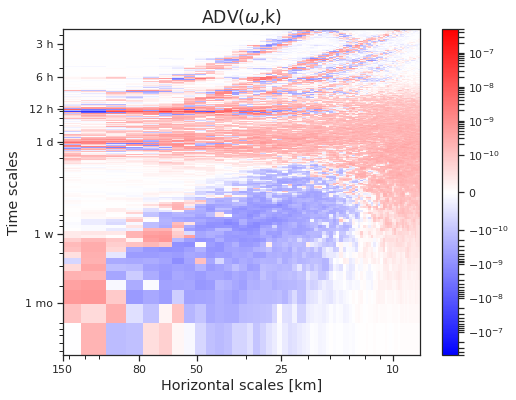

In [168]:
plot_cospectra(ki, omega, -adv_S[1:,:], "ADV($\omega$,k)", linthresh=1e-10, vminmax=[-5e-7,5e-7], bottom=True)